In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
from os.path import join, dirname
import os

import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
import itertools
import pickle
import admix
from admix import chi2_to_logpval
from scipy.stats import ttest_ind
import scipy
from IPython.display import display, Markdown, Latex

In [2]:
geno_sim_prefix = "EUR_0.2_AFR_0.8_7_10000"
# geno_sim_prefix = "EUR_0.5_AFR_0.5_10_10000"
data_dir = f"out/single_snp_test/{geno_sim_prefix}"
geno_data_dir = f"data/geno/{geno_sim_prefix}/"

In [3]:
anc = np.load(join(geno_data_dir, "anc.npy"))
phgeno = np.load(join(geno_data_dir, "phgeno.npy"))
legend = pd.read_csv(join(geno_data_dir, "legend.csv"))
subset_index = np.arange(0, anc.shape[1], 30)

anc = anc[:, subset_index]
phgeno = phgeno[:, subset_index]
legend = legend.loc[subset_index, :]
n_indiv = anc.shape[0] // 2
n_snp = anc.shape[1]
anc = anc.reshape(n_indiv, n_snp * 2)
phgeno = phgeno.reshape((n_indiv, n_snp * 2))
geno = admix.convert_anc_count(anc=anc, phgeno=phgeno)

# Plotting the allele frequency

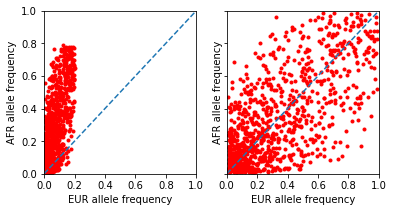

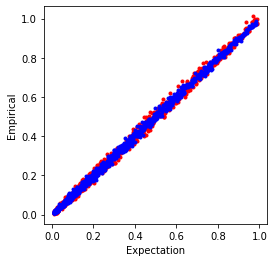

In [4]:
fig, axs = plt.subplots(figsize=(6, 3), ncols=2, sharex=True, sharey=True)
allele_freq = geno.mean(axis=0) / 2
eur_allele_freq = allele_freq[0 : n_snp]
afr_allele_freq = allele_freq[n_snp : (2 * n_snp)]
axs[0].plot(eur_allele_freq, afr_allele_freq , 'r.')
axs[1].plot(legend.EUR.values, legend.AFR.values, 'r.')

for ax_i in range(2):
    axs[ax_i].plot([0, 1], [0,1], '--')
    axs[ax_i].set_xlim(0, 1)
    axs[ax_i].set_ylim(0, 1)
    axs[ax_i].set_xlabel("EUR allele frequency")
    axs[ax_i].set_ylabel("AFR allele frequency")
plt.figure(figsize=(4, 4))
plt.plot(legend.EUR.values, eur_allele_freq / 0.2, 'r.')
plt.plot(legend.AFR.values, afr_allele_freq / 0.8, 'b.')
plt.xlabel("Expectation")
plt.ylabel("Empirical")
plt.show()

In [5]:
score_df_dict = dict()
var_g_list = [0.05, 0.075, 0.1, 0.2]
cov_list = [0.8, 1.0]
param_list = [param for param in itertools.product(var_g_list, cov_list)]
param_list.append((0.0, 0.0))

for var_g, cov in param_list:
    score_df_dict[(var_g, cov)] = pd.read_csv(join(data_dir, f"{var_g}_{cov}", "summary.csv"))

# Null simulation

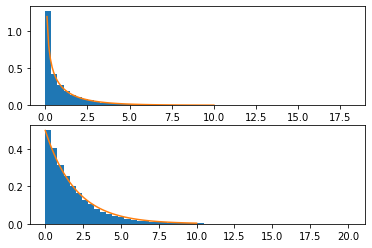

ADM        0.029406
ATT        0.050341
MIX        0.049920
SNP1       0.049248
SUM        0.036447
TRACTOR    0.051833
dtype: float64


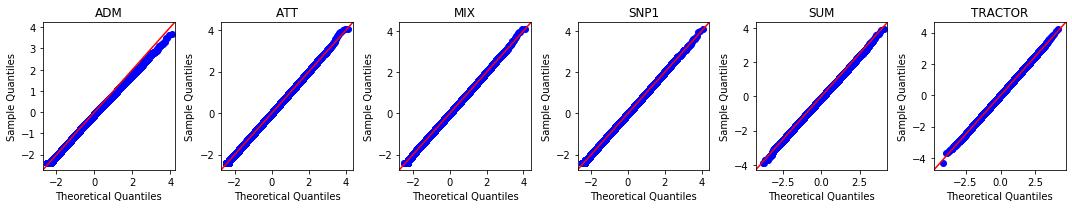

In [6]:
score_df = score_df_dict[(0.0, 0.0)].copy().dropna()
pval_df = score_df.iloc[:, 0:6].copy()

pval_df.iloc[:, 0:4] = stats.chi2.sf(pval_df.iloc[:, 0:4], df=1)
pval_df.loc[:, "SUM"] = stats.chi2.sf(pval_df.loc[:, "SUM"], df=2)

fig, axs = plt.subplots(nrows=2)
axs[0].hist(score_df.MIX, bins=50, density=True)
x_grid = np.linspace(0, 10, 100)
axs[0].plot(x_grid, stats.chi2.pdf(x_grid, df=1))
axs[1].hist(score_df.SUM, bins=50, density=True)
axs[1].plot(x_grid, stats.chi2.pdf(x_grid, df=2))
plt.show()
qq_fig, qq_axs = plt.subplots(1, pval_df.shape[1], figsize=(15,3))
for col_i, col in enumerate(pval_df.columns):
    zsc = admix.pval2zsc(pval_df[col].values)
    sm.qqplot(zsc, line="45", ax=qq_axs[col_i])
    qq_axs[col_i].set_title(col)
plt.tight_layout()

print(np.mean(pval_df.iloc[:, 0:6] < 0.05, axis=0))

# Power in alternative simulation

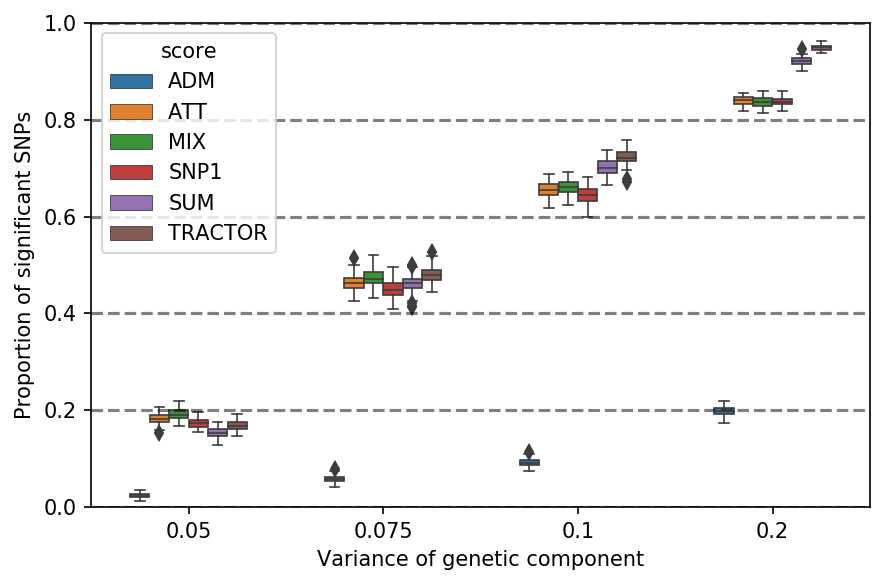

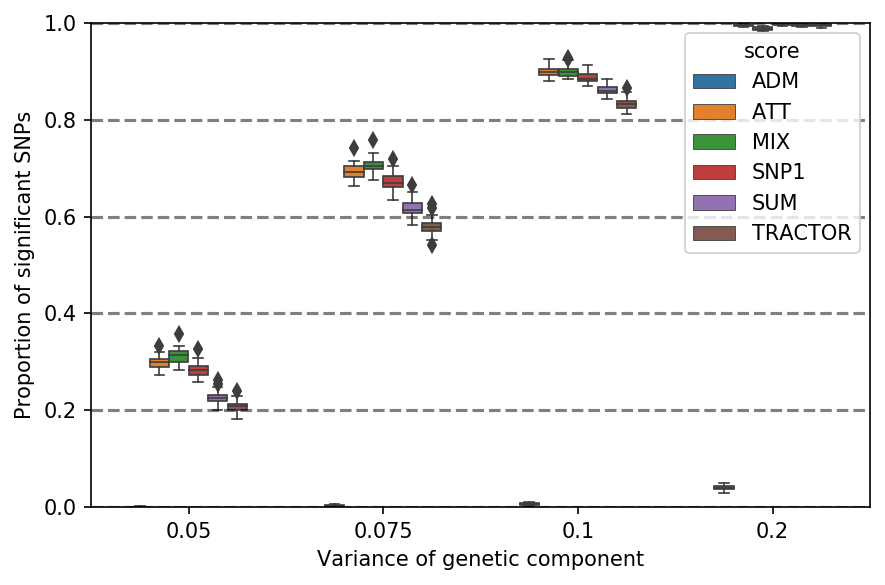

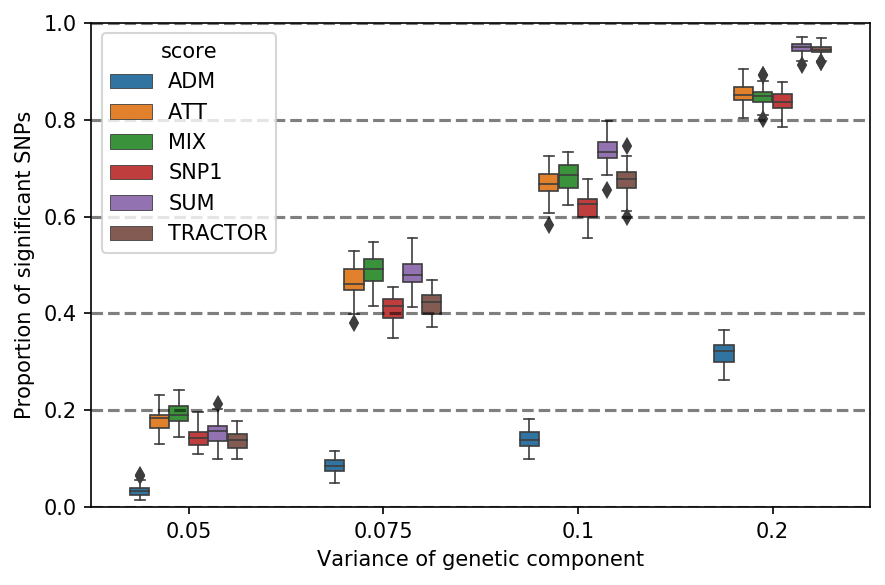

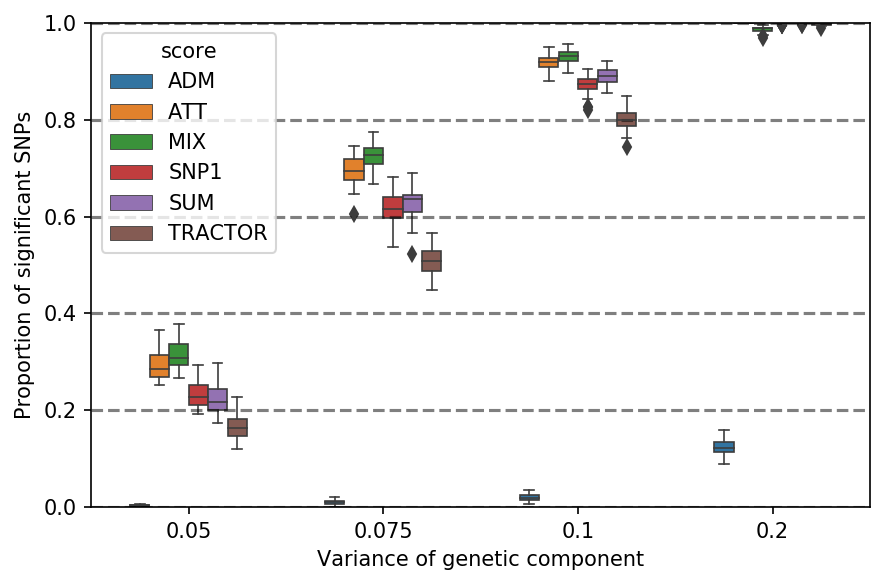

In [7]:
diff_snps = np.where(np.abs(legend.EUR.values - legend.AFR.values) > 0.2)[0]
for only_diff_snp in [False, True]:
    df = {"cov": [], "score": [], "var_g": [], "sig_prop": [], "sim_i": []}
    for cov_i, cov in enumerate(cov_list):
        for var_g in var_g_list:
            pval_df = score_df_dict[(var_g, cov)].copy().dropna()
            if only_diff_snp:
                pval_df = pval_df[pval_df.SNP_I.isin(diff_snps)]
            pval_df.iloc[:, 0:4] = stats.chi2.sf(pval_df.iloc[:, 0:4], df=1)
            pval_df.loc[:, "SUM"] = stats.chi2.sf(pval_df.loc[:, "SUM"], df=2)
            for score in pval_df.columns[0:6]:
                p_threshold = 1e-5 if score == "ADM" else 5e-8
                sig_prop = pval_df.groupby("SIM_I").apply(lambda x: np.mean(x[score] < p_threshold))
                sig_prop_mean = np.mean(sig_prop)
                sig_prop_se = np.std(sig_prop) / np.sqrt(len(sig_prop))
                score_n_sim = len(sig_prop)
                df["cov"].extend([cov] * score_n_sim)
                df["score"].extend([score] * score_n_sim)
                df["var_g"].extend([var_g] * score_n_sim)
                df["sig_prop"].extend(sig_prop)
                df["sim_i"].extend(sig_prop.index.values)
    df = pd.DataFrame(df)
    
    pivotted = df.groupby(["cov", "score", "var_g"])["sig_prop"].mean().reset_index().pivot(
        index=["cov", "var_g"], columns='score')
    
    
    file_prefix = f"{geno_sim_prefix}.only_diff" if only_diff_snp else f"{geno_sim_prefix}"
    
    # plotting
    for cov in cov_list:
        fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
        sns.boxplot(x="var_g", y="sig_prop",
                    hue="score",
                    width=0.6,
                    linewidth=0.8,
                    data=df[df["cov"] == cov], ax=ax)
        [ax.axhline(y=i, linestyle='--', color='k', alpha=0.5) for i in np.linspace(0, 1, 6)]
        plt.xlabel("Variance of genetic component")
        plt.ylabel("Proportion of significant SNPs")
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.savefig(f"manuscript/power/{file_prefix}.cov_{cov}.png", dpi=150)
        plt.show()
    
    
    pivotted.to_excel(f"manuscript/power/{file_prefix}.xlsx")
    